# Gravity model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.stats.api import ols
%pylab inline
RootPath = '/Users/CQ/Documents/Project1'
from datetime import datetime, timedelta, date
import time
from geopy.distance import vincenty
import geopandas as gp
import matplotlib.patches as mpatches
from descartes import PolygonPatch
from shapely.geometry.polygon import Polygon

plt.rcParams["figure.figsize"]=(20,9)

Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`


Populating the interactive namespace from numpy and matplotlib


In [2]:
twitter_file = pd.read_csv(RootPath + '/2016_02_18_sintetic.csv')
twitter_file.columns = ['Date','Time','ZipCode','User','ID']
twitter_file.Time = pd.to_datetime(twitter_file.Time, unit='s') - timedelta(hours=5) ## UTS - 5h NYC
twitter_file.Date = twitter_file.Time.dt.date
USzipcode = pd.read_csv(RootPath + '/USzipcode_XY(II).csv')
USzipcode.columns = ['ZipCode','lat','lon']

zipPath = RootPath + '/nyc-zip-code-tabulation-areas-polygons.geojson'
geo_NY = gp.read_file(zipPath)[['geometry', 'postalCode', 'Shape_Area']]
geo_NY.postalCode = geo_NY.postalCode.astype(int)

Data_zip = twitter_file.ZipCode.unique()
country_zip = USzipcode.ZipCode
PLACES = sort( list( set(Data_zip) & set(country_zip) ) )

missing_zip = set(geo_NY.postalCode.unique()) - set(PLACES)

# Part 1, OLS test and showcase of out degree of zip codes in NYC

In [3]:
data = pd.read_csv(RootPath + '/GravModel/Overall/Net2/Distance_Function/All_with_KLBin.csv')

In [4]:
fit_data = data[data.weight > 0]

X = fit_data.iloc[:,7:]
Y1 = log(fit_data.weight)   #first model, only targeting link weight
Y2 = log(fit_data.weight * fit_data.tweet1)
#second model, let the dependent variable be (link weight * number of tweets)

result1 = ols(y=Y1,x=X)
result2 = ols(y=Y2,x=X)
OLSmatrix1 = result1.summary_as_matrix
OLSmatrix2 = result2.summary_as_matrix

In [5]:
Wout1 = pd.DataFrame([(i,OLSmatrix1.loc['beta','K%d'%i]) for i in PLACES], columns=['postalCode', 'log(out)'])
Wout2 = pd.DataFrame([(i,OLSmatrix2.loc['beta','K%d'%i]) for i in PLACES], columns=['postalCode', 'log(out)'])

In [12]:
tweet_by_zip = twitter_file.groupby(twitter_file['ZipCode'])
c = tweet_by_zip.count().ID

In [6]:
def PlotMap(df, fig, zips = geo_NY, key = 'log(out)', layout = 111, loc_ix = 0, alpha = 0.7,
            mode = 1, density = False, cmap_name = 'RdPu', title = 'Community Map'):
    '''
    The function is for map plotting
    The arguments are:
    df       --- data frame
    fig      --- controls the figure to plot on
    key      --- the column name that user defined for determine color
    (default setting is 'part' for mode 1, partition)
    (may be 'weight' for mode 2, heatmap)
    layout   --- determines the subplot layout, default at 111
    loc_ix   --- the plot locatin index
    mode     --- 1 is for integer partitions, such as groups or clusters
             --- 2 is for non-integer partition, such as heatmap
    density  --- False for regular plotting
             --- True for density plotting (divided by its area)
    levels   --- the number of clusters if mode == 1
             --- else set it equal to 100 for heatmap (mode 2)
    
    '''
       
    ax = fig.add_subplot(layout + loc_ix)
    # if we are plotting partition
    if mode == 1:
        levels = 10
        p = zips.merge(df, on='postalCode', how='outer')
        m = len(p)
        p['part'] = p[key] - np.log(p.Shape_Area) if density else p[key]
        p['Rank'] = p.part.rank(method = 'min') * levels/m - 1.0/m
        p.Rank = p.Rank.fillna(-1).astype(int)
    # if we are plotting heatmap
    else:
        levels = 100
        p = zips.merge(df, on='postalCode', how='outer')
        m = len(p)
        p['part'] = p[key] - np.log(p.Shape_Area) if density else p[key]
        p['Rank'] = p.part.rank(method = 'min') * levels/m - 1.0/m
        p.Rank = p.Rank.fillna(-1).astype(int)
    color_func = matplotlib.cm.get_cmap(cmap_name)
    color = list(color_func(np.linspace(0,1,levels-1)))
    color.append([0.,0.,0.,1.])

    #creating percentage interval along with its labels
    percent = [i*100.0/levels for i in xrange(levels)]
    percent_label = ["{:2.0f}".format(percent[i])+'% ~ '+"{:2.0f}".format(percent[i+1])+'%'
                     for i in xrange(levels - 1)]
    percent_label.append('> '+"{:2.0f}".format(percent[-1])+'%')
    interval = [np.percentile(p.part.dropna(), i) for i in percent]
    interval_label = ["({:2.2f}".format(interval[i])+' ~ '+"{:2.2f}".format(interval[i+1])+')'
                      for i in xrange(levels - 1)]
    interval_label.append('(> '+"{:2.2f}".format(interval[-1])+')')
    label = [percent_label[i]+' '+interval_label[i] for i in xrange(levels)]
    
    missing_zips = sort (list (set(zips.postalCode.unique()) - set(PLACES)) )
    if len(missing_zips) > 0:
        label.append('NO DATA')
        color.append([1,0,0,1])
    #part = [label[i] for i in p.Rank]

    #color = [[0.3+0.7*i,0.9*i,1] for i in np.linspace(1,0,levels-1)]
    #color.append([0.1,0,1])
    for s in xrange(m):
        poly = Polygon(p.geometry[s])
        c = color[p.Rank[s]][0:3]
        ax.add_patch(PolygonPatch(poly, fc = c, ec = 'k', alpha = alpha, zorder = 2))
      
    handles = [mpatches.Patch( color = color[i][0:3], label=label[i]) for i in xrange(len(color))]
    plt.legend(handles = handles)
    plt.title(title, fontweight = 'bold', size = 18)
    ax.axis('scaled')

In [7]:
missing_zip

{10043, 10155, 10162, 11096, 11451}

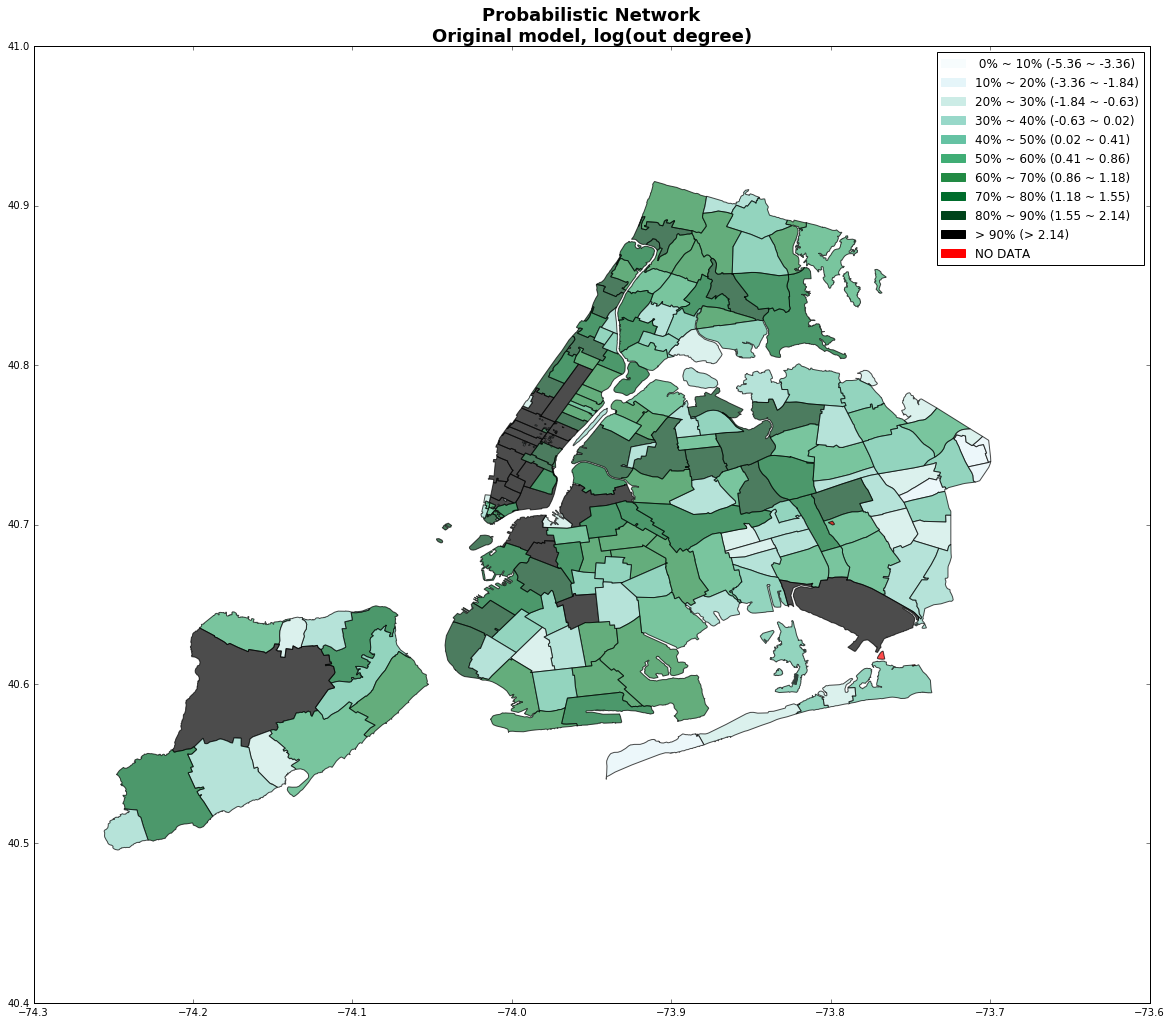

In [134]:
fig1 = plt.figure(figsize=(20,20))
PlotMap(Wout1, fig1, title = 'Probabilistic Network\nOriginal model, log(out degree)',
        layout = 111, cmap_name = 'BuGn')#, density=True)

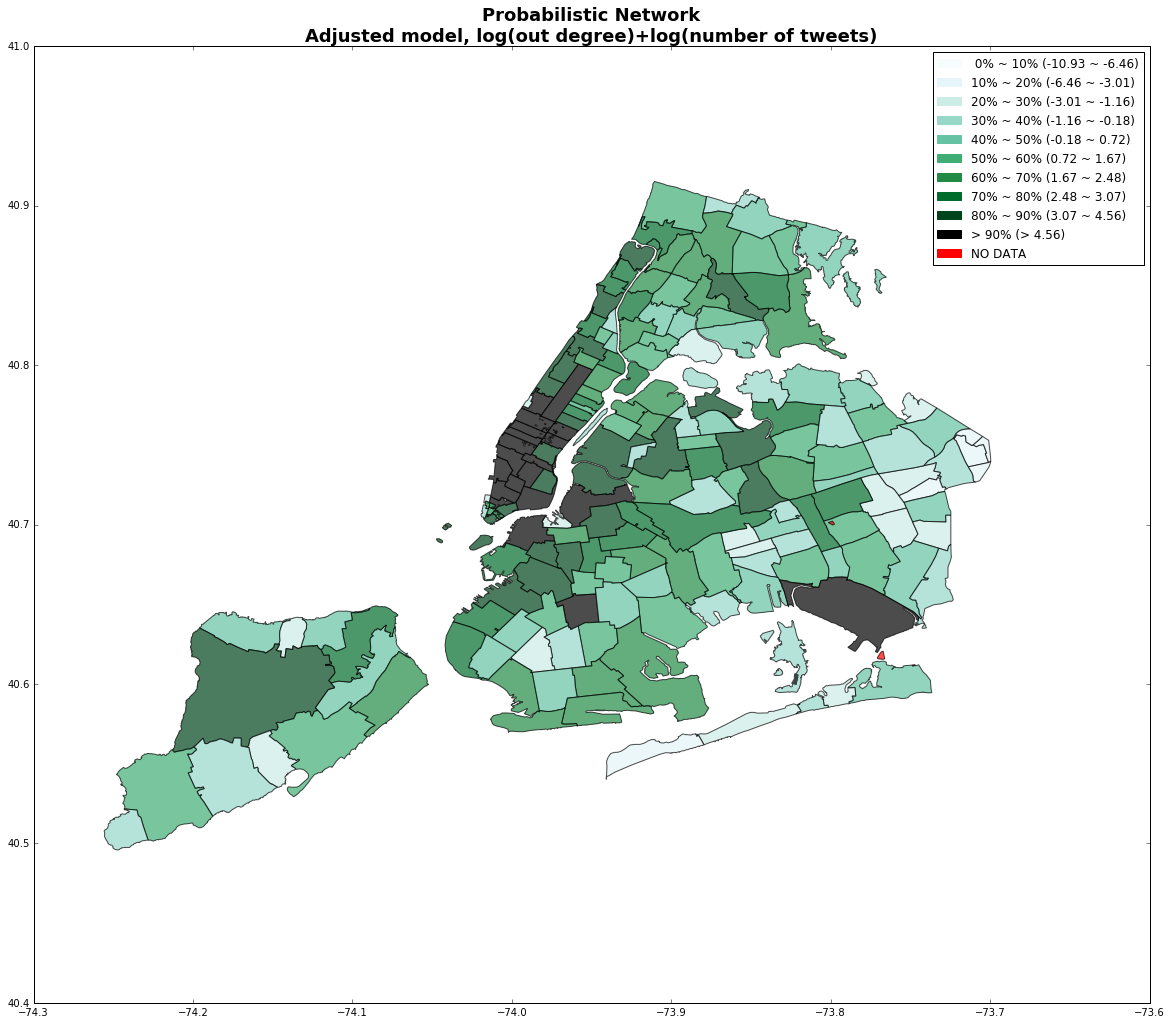

In [133]:
fig2 = plt.figure(figsize=(20,20))
PlotMap(Wout2, fig2, title = 'Probabilistic Network\nAdjusted model, log(out degree)+log(number of tweets)',
        layout = 111, cmap_name = 'BuGn')

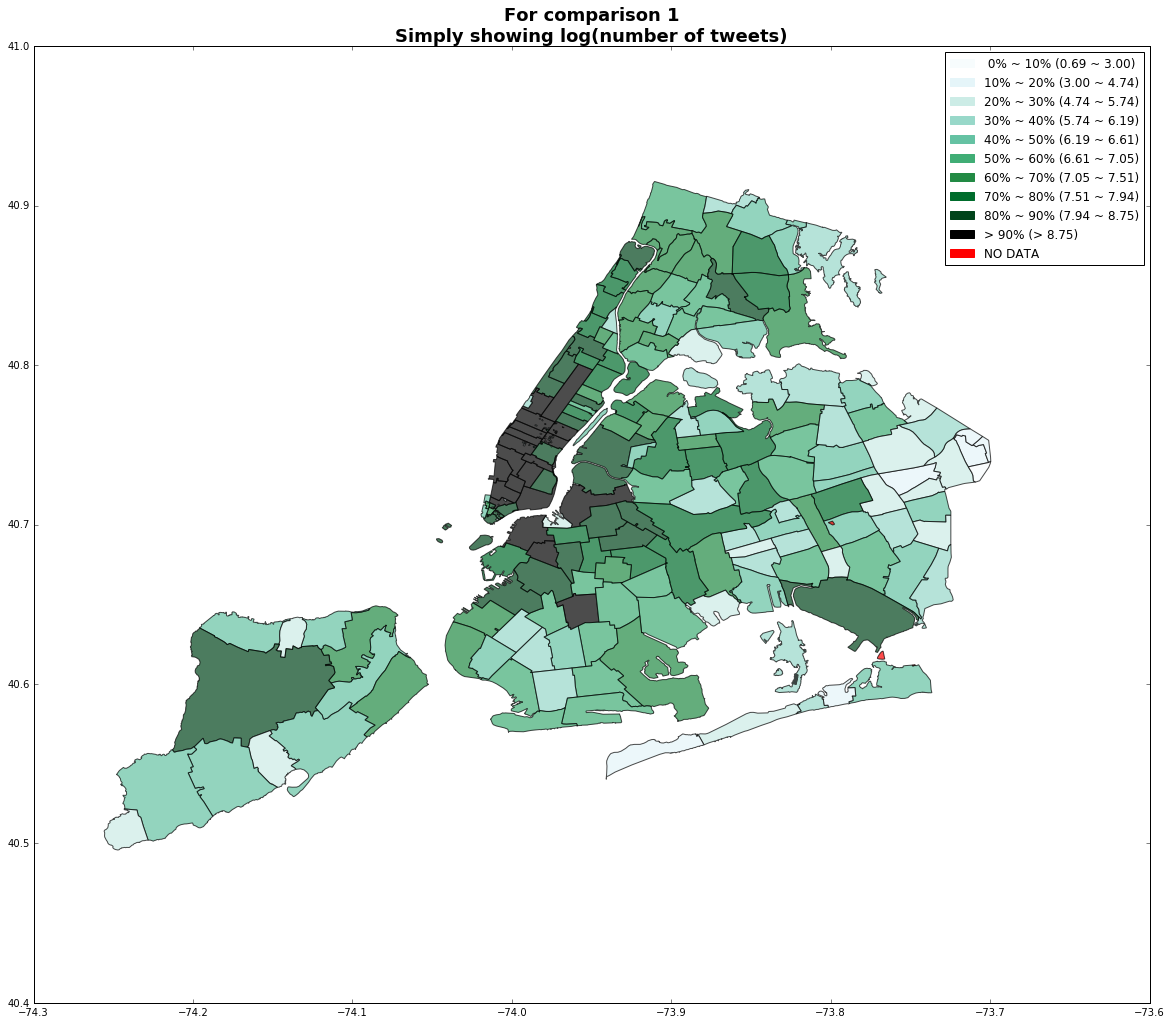

In [13]:
fig3 = plt.figure(figsize=(20,20))
PlotMap(pd.DataFrame({'postalCode':c.index, 'log(out)':np.log(c.values)}), fig3,
        title = 'For comparison 1\nSimply showing log(number of tweets)',
        layout = 111, cmap_name = 'BuGn')

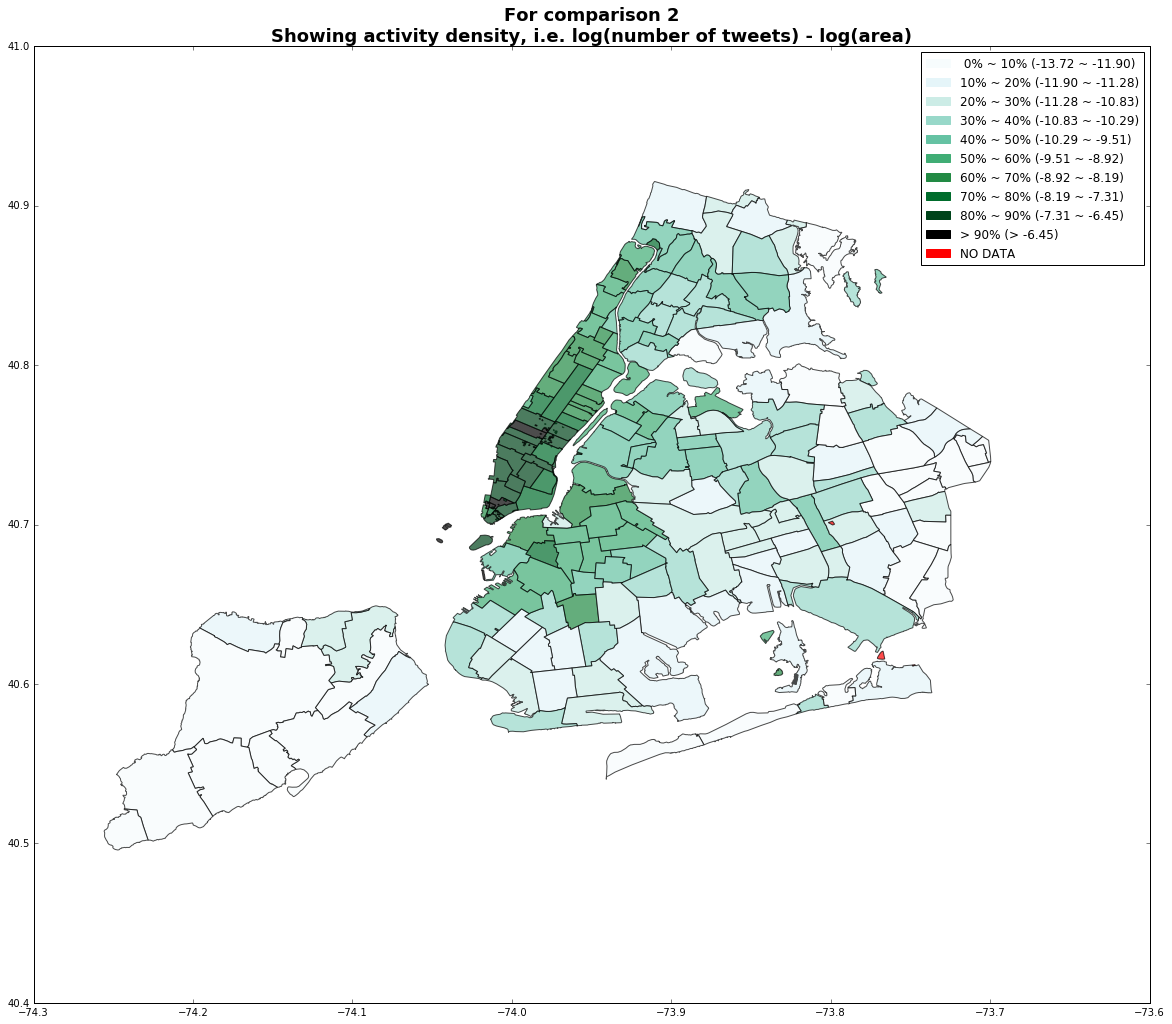

In [14]:
fig4 = plt.figure(figsize=(20,20))
PlotMap(pd.DataFrame({'postalCode':c.index, 'log(out)':np.log(c.values)}), fig4,
        title = 'For comparison 2\nShowing activity density, i.e. log(number of tweets) - log(area)',
        layout = 111, cmap_name = 'BuGn',density=True)

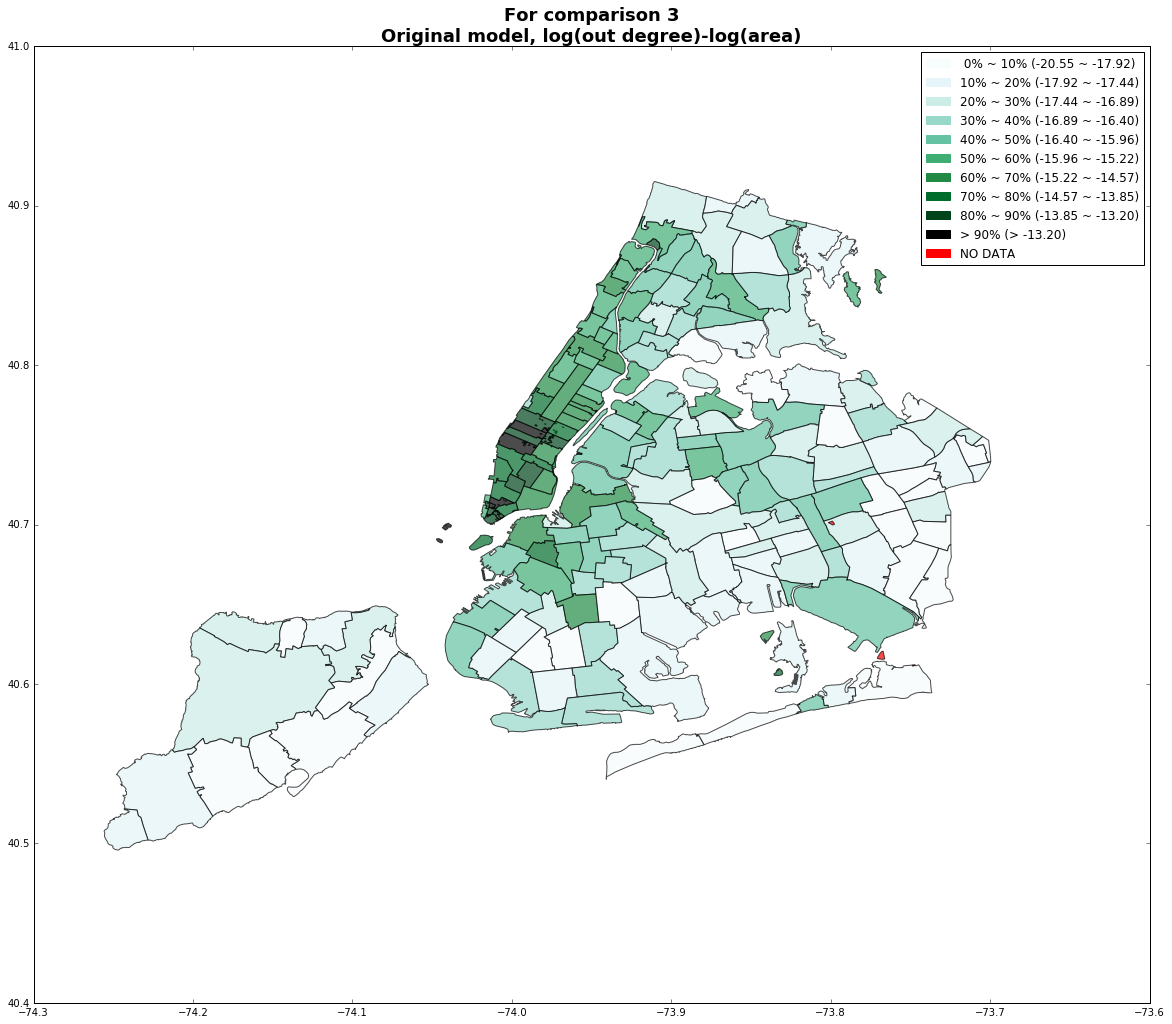

In [135]:
fig5 = plt.figure(figsize=(20,20))
PlotMap(Wout1, fig5, title = 'For comparison 3\nOriginal model, log(out degree)-log(area)',
        layout = 111, cmap_name = 'BuGn', density=True)

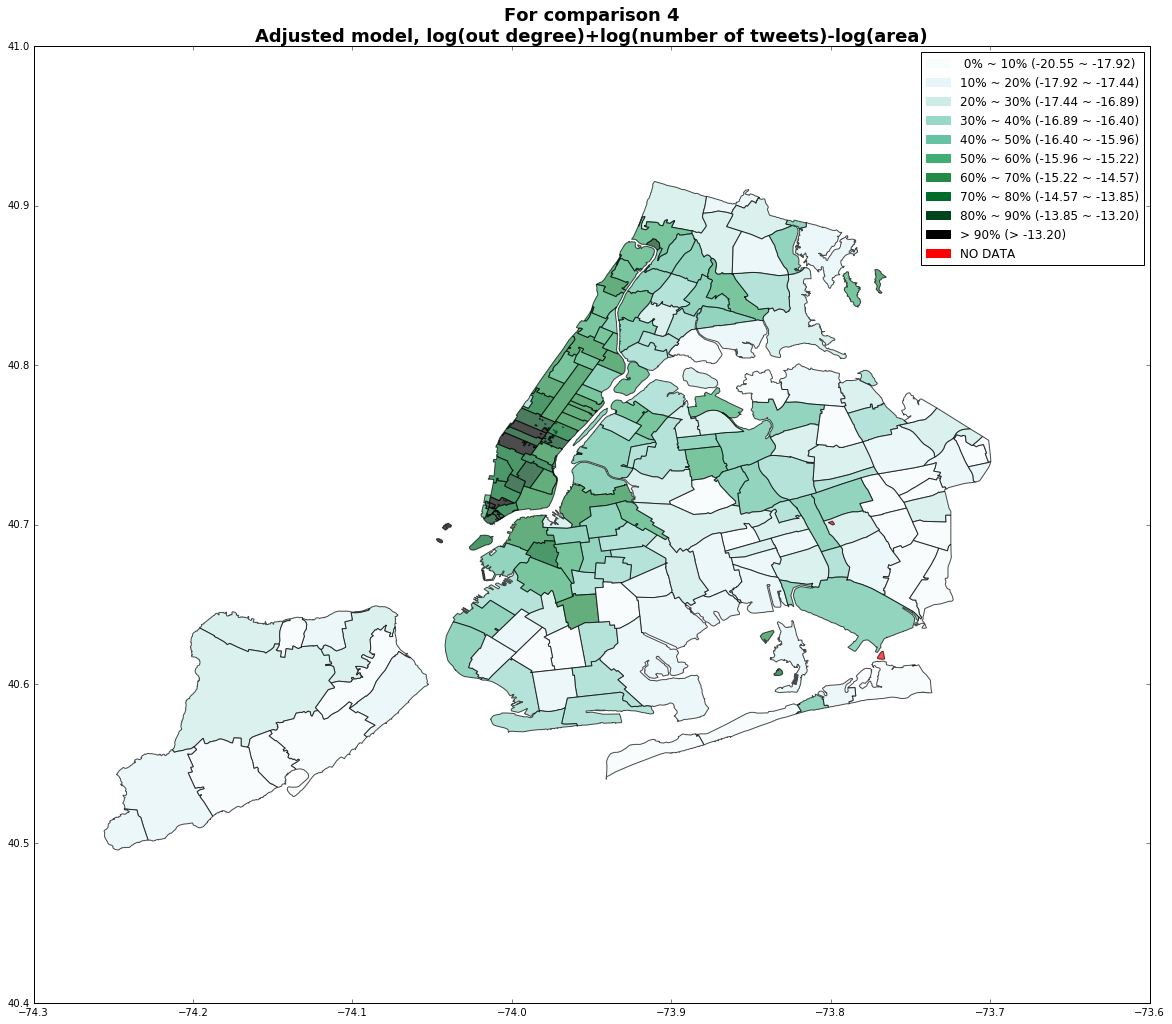

In [136]:
fig6 = plt.figure(figsize=(20,20))
PlotMap(Wout1, fig6, title = 'For comparison 4\nAdjusted model, log(out degree)+log(number of tweets)-log(area)',
        layout = 111, cmap_name = 'BuGn', density=True)

# You may notice the difference here:
## The out degree plot is darker if the area is not considered, in other words, density plot is brighter. This is due to the fact that NYC has multiple zip codes/places with tiny area, resulting in "low" activity in terms of absolute ranking (out degree), but "not so low anymore" if divided by its area.

In [17]:
def PlotMap2(df, fig, show=0, zips = geo_NY, key = 'log(tweets)', layout = 111, loc_ix = 0, alpha = 0.7,
            density = False, title = 'Community Map'):
       
    ax = fig.add_subplot(layout + loc_ix)
    # if we are plotting partition
    levels = 10
    p = zips.merge(df, on='postalCode', how='outer')
    m = len(p)
    p['part'] = (p[key] - np.log(p.Shape_Area)) if density else p[key]
    p['Rank'] = p.part.rank(method = 'min') * levels/m - 1.0/m
    p.Rank = p.Rank.fillna(-1).astype(int)

    for s in xrange(m):
        poly = Polygon(p.geometry[s])
        c = 'b' if p.Rank[s] == show else 'w'
        ax.add_patch(PolygonPatch(poly, fc = c, ec = 'k', alpha = alpha if c == 'w' else 1, zorder = 2))
      
    plt.title(title, fontweight = 'bold', size = 18)
    ax.axis('scaled')

## For example, when we consider the bottom 10% of zip codes in NYC, if we plot its absolute ranking, it looks like (note that the majority of them are located in Manhattan)
## We have more than 20 (23 to be specific) zip codes with less than 50,000 area here, which can only be seen as dots on the scale of a citywide map

In [18]:
LogNum_of_tweets = pd.DataFrame({'postalCode':c.index, 'log(tweets)':np.log(c.values)})

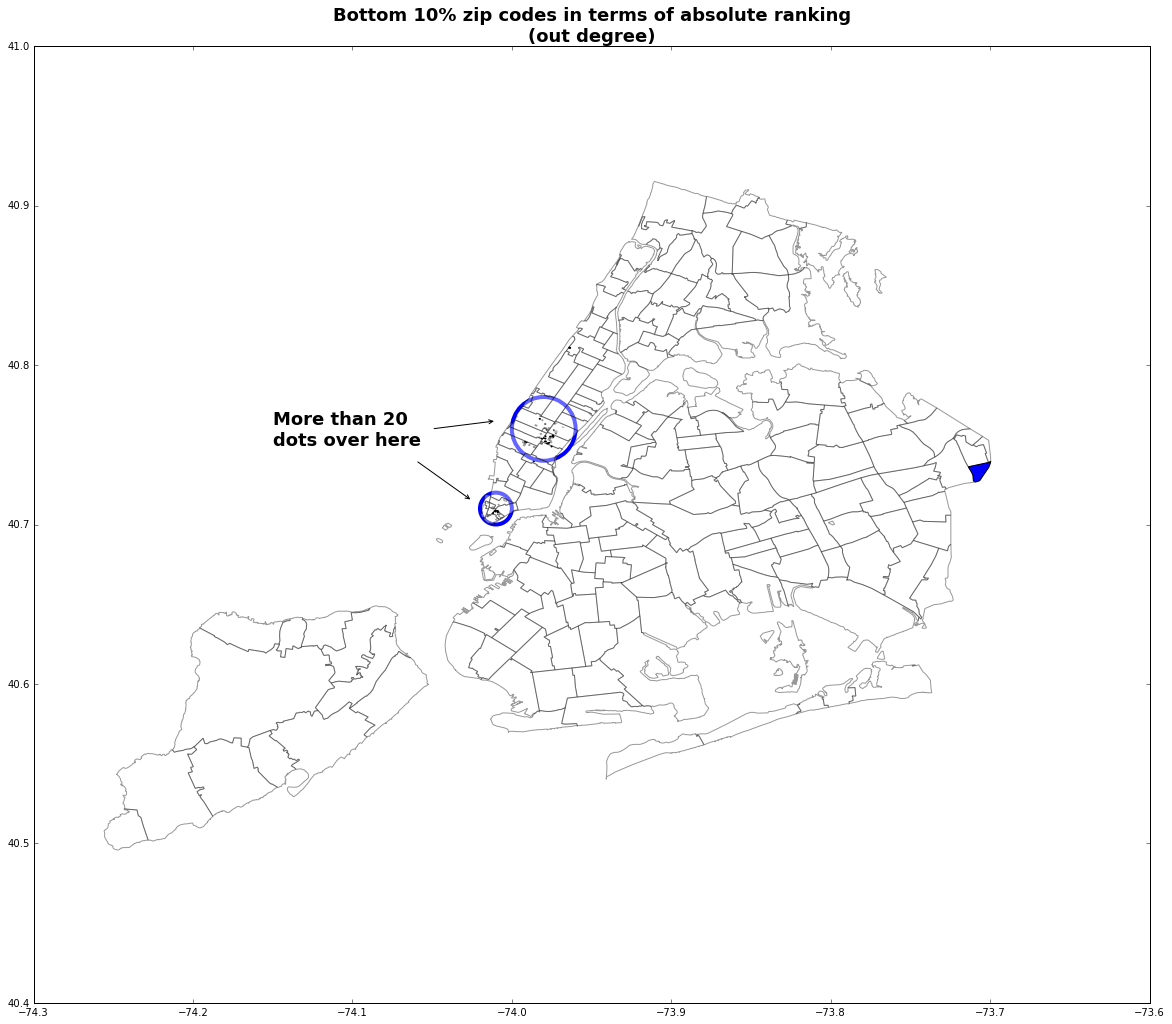

In [19]:
fig7 = plt.figure(figsize=(20,20))
PlotMap2(LogNum_of_tweets, fig7,
        density=False, alpha = 0.4, title = 'Bottom 10% zip codes in terms of absolute ranking\n(out degree)')
ax = fig7.gca()
circ1 = plt.Circle((-73.98, 40.76), radius=0.02, fc = 'w', ec='b', alpha = 1, linewidth = 4)
circ2 = plt.Circle((-74.01, 40.71), radius=0.01, fc = 'w', ec='b', alpha = 1, linewidth = 4)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.text(-74.15, 40.75, 'More than 20\ndots over here',fontsize=18, fontweight='bold')
ax.annotate("",xy=(-74.01, 40.765), xytext=(-74.05, 40.76), arrowprops=dict(arrowstyle="->"))
ax.annotate("",xy=(-74.025, 40.715), xytext=(-74.06, 40.74), arrowprops=dict(arrowstyle="->"))

## But if we plot the "relative ranking"--density, then the bottom 10% becomes

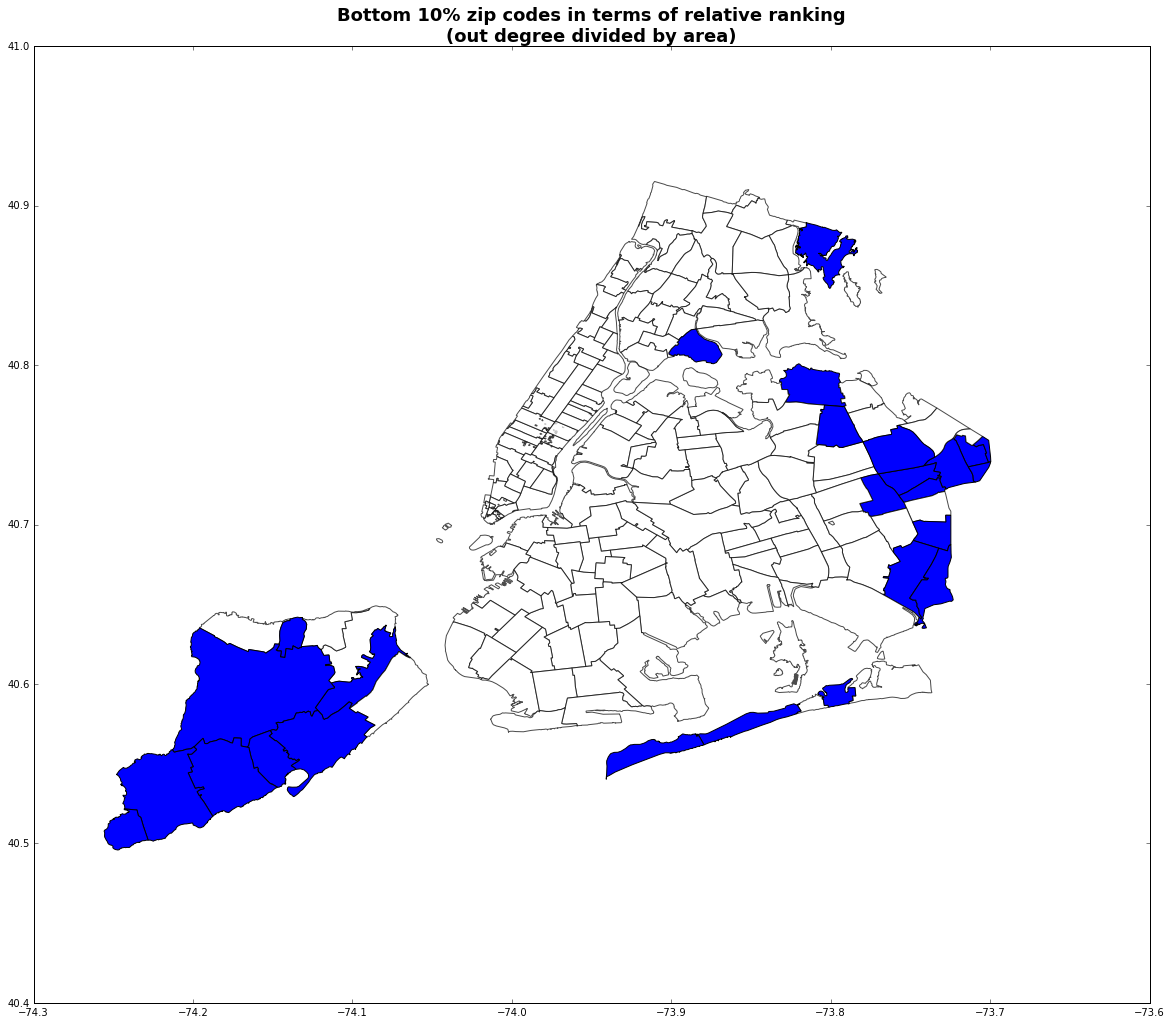

In [20]:
fig8 = plt.figure(figsize=(20,20))
PlotMap2(LogNum_of_tweets, fig8,
         density=True, title = 'Bottom 10% zip codes in terms of relative ranking\n(out degree divided by area)')

## Since we are counting our percentiles "zipcode-wise" rather than "area-wise", this discrepancy is reasonable and quite interesting to see

## We take a glance at the relationship of $ln(W^{out}_i)$ vs $ln(T_i)$
## where $T_i$ denotes the number of tweets posted within zip code $i$

In [23]:
def Draw_CI_for_OLS(X,Y):
    result = ols(x=X,y=Y)
    (c,d) = result.beta

    plt.plot(X, Y, 'b.', label = 'Observations')
    plt.plot(X,  c*X+d, '-r', lw=2, label='Fitted line')
    print('The coefficients of this model are: a = %f, b = %f'%(c,d))
    print('The R square of this model is %f'%result.r2)

    y_err = Y-c*X-d
    p_x = np.arange(X.min(),X.max(),0.2)
    # now calculate confidence intervals for new test x-series
    t = 2.327               # appropriate t value (where n=242, two tailed 98%, it's practically normal distribution)
    s_err = np.sum(y_err**2)   # sum of the squares of the residuals
    n = len(X)
    confs = t * np.sqrt( (s_err/(n-2)) * (1.0/n + (p_x-X.mean())**2 / (np.sum(X**2)-n*(X.mean()**2)) ) )
    predict = t * np.sqrt( (s_err/(n-2)) * (1+ 1.0/n + (p_x-X.mean())**2 / (np.sum(X**2)-n*(X.mean()**2)) ) )
    p_y = c*p_x + d
    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower_ci = p_y - confs
    upper_ci = p_y + confs
    lower_pred = p_y - predict
    upper_pred = p_y + predict
    # plot confidence limits
    plt.plot(p_x,lower_ci,'g-',lw = 2, label='Lower confidence limit (98%)')
    plt.plot(p_x,upper_ci,'g-',lw = 2, label='Upper confidence limit (98%)')
    plt.plot(p_x,lower_pred,'c--',lw = 2, label='Lower prediction limit')
    plt.plot(p_x,upper_pred,'c--',lw = 2, label='Upper prediction limit')
    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=18)
    # show the plot
    plt.show()
    return result

The coefficients of this model are: a = 0.908330, b = -5.772895
The R square of this model is 0.923827


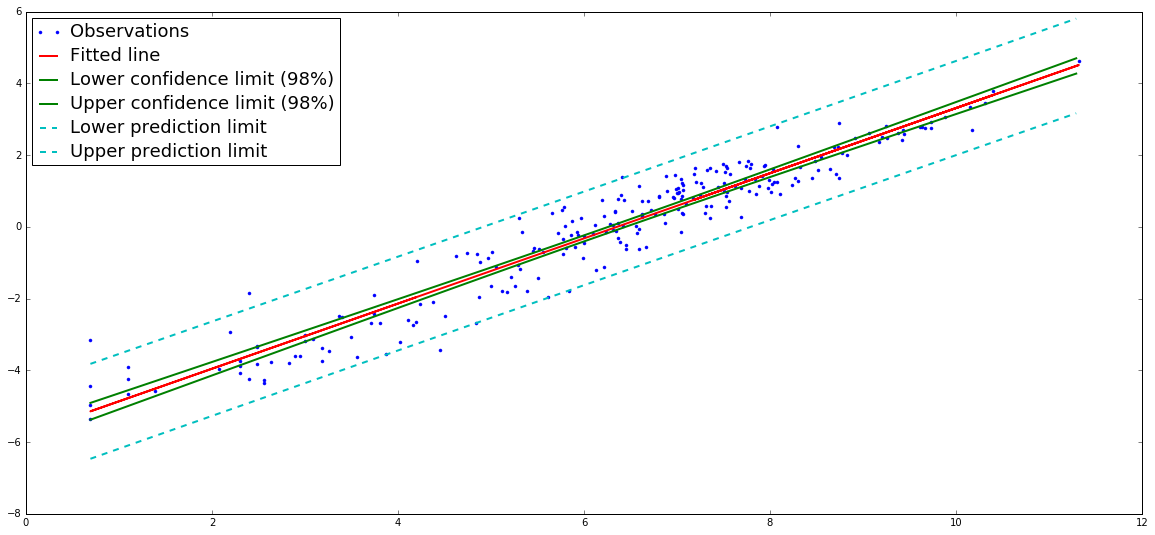

In [26]:
WOvsT = Draw_CI_for_OLS(LogNum_of_tweets['log(tweets)'],Wout1['log(out)'])

In [27]:
exp(WOvsT.beta[1])

0.0031107376162022604

### So the values of $ln(W^{out}_i)$ are  showing strong linear correlation with $ln(T_i)$, which inspires us to predict $ln(W^{out}_i)$ as long as $T_i$ are available.
### And the model looks like this $$ln(W^{out}_i) \approx 0.908330 \cdot ln(T_i) - 5.772895$$ or equivalently, $$W^{out}_i \approx  0.00311 \cdot T^{0.908330}_i$$

## And it's worth noticing that the relationship between $W^{out}_i$ and $T_i$ is underlinear, 1 is not even in our 95% confidence interval (upper CI limit is 0.9413 as shown below).

In [28]:
WOvsT


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         242
Number of Degrees of Freedom:   2

R-squared:         0.9238
Adj R-squared:     0.9235

Rmse:              0.5595

F-stat (1, 240):  2910.7147, p-value:     0.0000

Degrees of Freedom: model 1, resid 240

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.9083     0.0168      53.95     0.0000     0.8753     0.9413
     intercept    -5.7729     0.1118     -51.62     0.0000    -5.9921    -5.5537
---------------------------------End of Summary---------------------------------

# Part 2, distance function and coefficients (overall, complete dataset)

## Next we present the $ln(f(distance))$ with respect to the average distance within each bin, where the bins are determined by the percentile of distribution of all distance data in NYC

### Note: Since all the coefficients here are obtained without zero-weighted links (otherwise $log(0)$ would cause computation error), the following fit and estimation are also conducted with nonzero-weighted links, experiments show no distince difference if zero-weighted links are included.

In [56]:
log_dist_mean = pd.Series(np.log( [fit_data[fit_data.DistRank == i].distance.mean() for i in xrange(100)] ))
log_f_dist = pd.Series([OLSmatrix1.loc['beta','bin%d'%i] for i in xrange(100)])

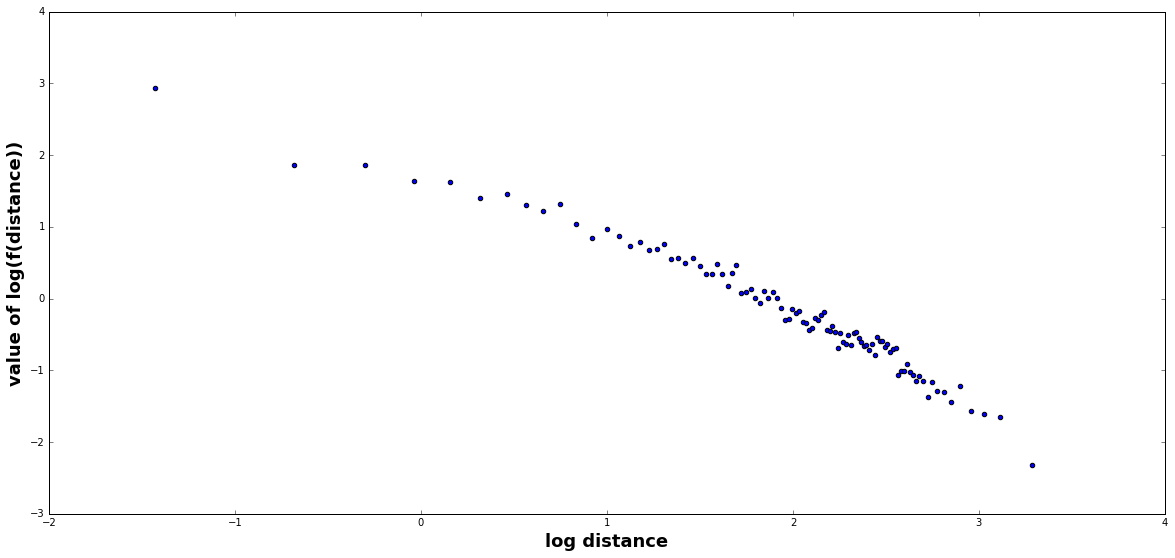

In [57]:
plt.scatter(log_dist_mean, log_f_dist)
plt.xlabel('log distance', fontsize=18, fontweight='bold')
plt.ylabel('value of log(f(distance))', fontsize=18, fontweight='bold')

# Model 1 $$f(dist) = \frac {1}{a \cdot dist + b}$$

The coefficients of this model are a = 0.256155, b = -0.583011
The R square of this model is 0.872454


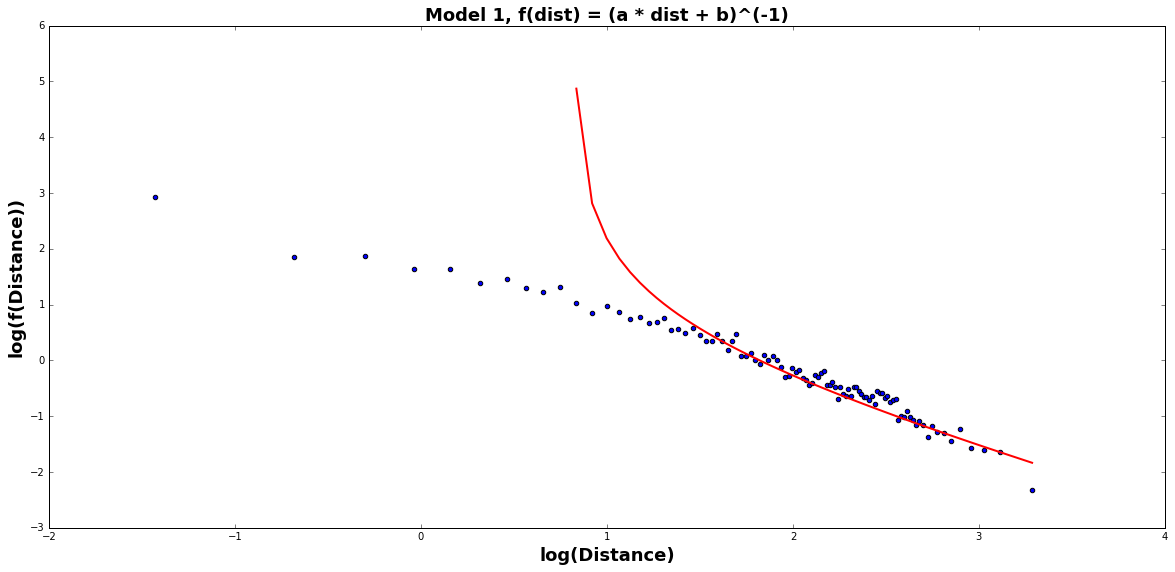

In [58]:
plt.scatter(log_dist_mean, log_f_dist)
plt.ylabel('log(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('log(Distance)', fontweight = 'bold', size = 18)
model1 = ols(y = 1.0/exp(log_f_dist), x = pd.DataFrame(np.exp(log_dist_mean)))
(a1,b1) = model1.beta
plt.plot(log_dist_mean, [-log(a1*exp(i)+b1) for i in log_dist_mean], '-r', lw = 2)
plt.title('Model 1, f(dist) = (a * dist + b)^(-1)', fontweight = 'bold', size = 18)

print('The coefficients of this model are a = %f, b = %f'%(a1,b1))
print('The R square of this model is %f'%model1.r2)

In [59]:
model1


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <0> + <intercept>

Number of Observations:         100
Number of Degrees of Freedom:   2

R-squared:         0.8725
Adj R-squared:     0.8712

Rmse:              0.5100

F-stat (1, 98):   670.3497, p-value:     0.0000

Degrees of Freedom: model 1, resid 98

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             0     0.2562     0.0099      25.89     0.0000     0.2368     0.2755
     intercept    -0.5830     0.0996      -5.85     0.0000    -0.7782    -0.3878
---------------------------------End of Summary---------------------------------

# Model 2 $$f(dist) = e^b \cdot dist^a$$
## In other words, $ln(f(dist)) = a \cdot ln(dist) + b$

The coefficients of this model are a = -1.060583, b = 1.877584
The R square of this model is 0.956324


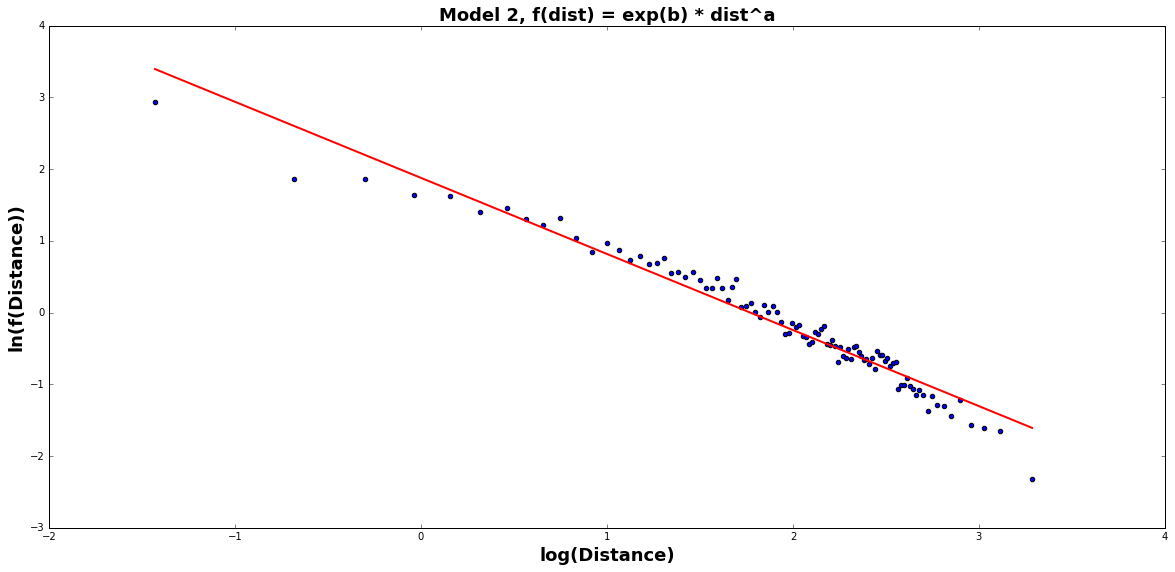

In [108]:
model2 = ols(y = log_f_dist, x = log_dist_mean)
(a2,b2) = model2.beta

plt.scatter(log_dist_mean, log_f_dist)
plt.title('Model 2, f(dist) = exp(b) * dist^a', fontweight = 'bold', size = 18)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('log(Distance)', fontweight = 'bold', size = 18)
plt.plot(log_dist_mean,[a2*i+b2 for i in log_dist_mean],'-r',lw=2)
print('The coefficients of this model are a = %f, b = %f'%(a2,b2))
print('The R square of this model is %f'%model2.r2)

In [61]:
model2


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         100
Number of Degrees of Freedom:   2

R-squared:         0.9563
Adj R-squared:     0.9559

Rmse:              0.1895

F-stat (1, 98):  2145.7995, p-value:     0.0000

Degrees of Freedom: model 1, resid 98

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -1.0606     0.0229     -46.32     0.0000    -1.1055    -1.0157
     intercept     1.8776     0.0476      39.43     0.0000     1.7843     1.9709
---------------------------------End of Summary---------------------------------

### From both the plots and the quantitative indicator $R^2$, we can see that model 2 has better approximation so we'll go a step furthur with model 2.

# Part 3, distance function and coefficients (see if they vary significantly over time) --conducted with model 2

## A) Split dataset into sub-categories according to date

In [35]:
start_date = twitter_file.iloc[0,0]
end_date = twitter_file.iloc[-1,0]
day_count = (end_date-start_date).days + 1
DateList = [start_date + timedelta(n) for n in xrange(day_count)]

In [50]:
def Initiate_forKLBin(df):
    
    def Count_tweet(series):
        return (c[series.zip1] , c[series.zip2])
    
    def ProbNetWeight(series):
        delta = (series.zip1 == series.zip2)+0
        return sum(temp.loc[:,series.zip1] * (temp.loc[:,series.zip2] - delta)/T/(tc[ix_tc]-1))
    
    def Dist_Centr_Comp(df, city_ziplist = PLACES, map_ziplist = USzipcode):
        '''
        Extract zip codes' coordinates from USzipcode.csv, calculate the distance for each zip pair
        '''
        leng = len(df)
        ziplist = map_ziplist[map_ziplist.iloc[:,0].isin(city_ziplist)]
        zipdict = {int(ziplist.iloc[i,0]):(ziplist.iloc[i,1],ziplist.iloc[i,2]) for i in xrange(len(ziplist))}
        network = df.loc[:,['zip1','zip2']]
        distance = [vincenty(zipdict[network.zip1[i]], zipdict[network.zip2[i]]).miles for i in xrange(leng)]
        df['distance'] = distance
        return df

    def KLBin_init(df, bins=100):
        dataset = pd.DataFrame(df[df.distance > 0], copy = True)
        len1 = len(dataset)
        len2 = len(PLACES)
        #convert the rank into our 100-bin distribution
        dataset['DistRank'] = (dataset.distance.rank(method = 'min')-1)*100/len1        
        dataset.DistRank = dataset.DistRank.astype(int)
        
        K_label = ['K%d'%i for i in PLACES]
        L_label = ['L%d'%i for i in PLACES]
        bin_label = ['bin%d'%i for i in range(bins)]
        #bin_rank = (stat.rankdata(dataset.distance, 'min')-1)*bins/len1
        K = np.matrix(dataset.zip1).T * np.matrix(np.ones((1,len2))) == np.matrix(np.ones(len1)).T * np.matrix(PLACES)
        K = pd.DataFrame(K*1, columns = K_label)
        L = np.matrix(dataset.zip2).T * np.matrix(np.ones((1,len2))) == np.matrix(np.ones(len1)).T * np.matrix(PLACES)
        L = pd.DataFrame(L*1, columns = L_label)
        Bin = np.matrix(dataset.DistRank).T * np.matrix(np.ones((1,bins))) == np.matrix(np.ones(len1)).T * np.matrix(range(bins))
        Bin = pd.DataFrame(Bin*1, columns = bin_label)
        dataset.index = range(len1)
        data = pd.concat([dataset, K, L, Bin], axis = 1)
        data.fillna(0, inplace = True)
        return data

    if df.empty:
        return df
    else:
        data_zip = df.ZipCode.unique()
        places = sort( list( set(data_zip) & set(country_zip) ) )
        dataset = pd.DataFrame(df, copy = True)
        tweet_by_user = df['ZipCode'].groupby(df['User'])
        a = tweet_by_user.value_counts()
        b = a.unstack(level = -1).fillna(0)
        tweet_by_zip = dataset.groupby(dataset['ZipCode'])
        c = tweet_by_zip.count().ID
        #c is the series, containing number of tweets on each zip code
        user = np.sort(dataset.User.unique())
        #places = list(np.sort(dataset.ZipCode.unique()))
        b = pd.DataFrame(b, columns = PLACES, index = user)
        #b is the matrix where each entry b_{i,j} is the number of tweets that user i posted on zip code j
        tc = b.sum(axis = 1)
        #tc is the total number of tweets that each user has posted
        #note that b.sum() is the same as c above
        #select the index of tc larger than 1(in order to make all computation valid when we proceed to/
        #let (tc-1) sit on the denominator)
        ix_tc = tc > 1
        tc = tc[ix_tc]  #only consider those people who has posted more than once
        temp = b[ix_tc]  #only consider those people who has posted more than once
        T = temp.sum().sum()*1.0  #T is the total number of tweets posted by the users who has posted more than one tweet
    
        data = pd.DataFrame([(i,j) for i in places for j in places], columns=['zip1','zip2'])

        tweet_count = data.apply(Count_tweet, axis = 1)

        for i in range(2):
            data['tweet%d'%(i+1)] = [j[i] for j in tweet_count]

        data['weight'] = data.apply(ProbNetWeight, axis = 1)
        data = KLBin_init(Dist_Centr_Comp(data))
        return data

In [51]:
for single_day in DateList:
    df = pd.read_csv(RootPath + '/GravModel/TimeSeries/General/'+str(single_day)+'.csv')
    df = Initiate_forKLBin(df)
    df.to_csv(RootPath + '/GravModel/TimeSeries/Reboot/'+str(single_day)+'.csv', index=False)

## B) Run OLS for each day and store coefficients a, b

In [97]:
def OLSforKLBin(df):
    if df.empty:
        return (0,0)
    else:
        data = df[df.weight > 0]
        result = ols(x= data.iloc[:,7:], y= log(data.weight))
        OLSmatrix = result.summary_as_matrix
        #df or data?
        log_dist_mean = pd.Series(np.log( [data[data.DistRank == i].distance.mean() for i in xrange(100)] ))
        log_f_dist = pd.Series([OLSmatrix.loc['beta','bin%d'%i] for i in xrange(100)])
        model = ols(y = log_f_dist, x = log_dist_mean)
        (a,b) = model.beta
        return (a,b)

In [98]:
# Coefficients = [(0,0)] * len(DateList)
# for single_day in DateList:
#     df = pd.read_csv(RootPath + '/GravModel/TimeSeries/Reboot/'+str(single_day)+'.csv')
#     Coefficients[DateList.index(single_day)] = OLSforKLBin(df)

In [38]:
# Coef_A = [Coefficients[i][0] for i in xrange(len(Coefficients))]
# Coef_B = [Coefficients[i][1] for i in xrange(len(Coefficients))]

In [109]:
Coefficients = pd.read_csv(RootPath + '/GravModel/TimeSeries/Coefficients_ProbNet.csv')

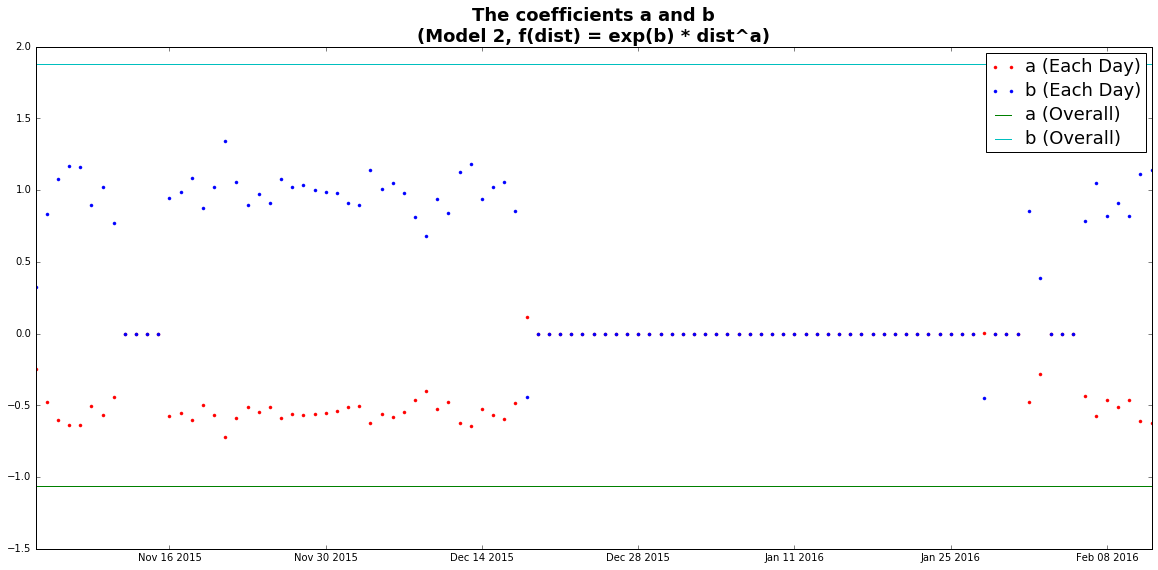

In [137]:
plt.plot(DateList, Coefficients['Coef_A'], 'r.', label='a (Each Day)')
plt.plot(DateList, Coefficients['Coef_B'], 'b.', label='b (Each Day)')
plt.axhline(a2, color='g', label='a (Overall)')
plt.axhline(b2, color='c', label='b (Overall)')
plt.legend(loc=0)
plt.title('The coefficients a and b\n(Model 2, f(dist) = exp(b) * dist^a)', fontweight = 'bold', size = 18)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=18)
plt.show()

## The zeros indicate lack of data on that particular day. 

Standard deviation of these coefficients (non-zero part)

In [130]:
Coefficients[Coefficients['Coef_A']!=0].std()

Coef_A    0.143265
Coef_B    0.324681
dtype: float64

Mean of these coefficients (non-zero part)

In [128]:
Coefficients[Coefficients['Coef_A']!=0].mean()

Coef_A   -0.511951
Coef_B    0.898864
dtype: float64

Compare with the coefficients calculated before with complete dataset

In [129]:
model2.beta

x           -1.060583
intercept    1.877584
dtype: float64

# Here we can see that the coefficients calculated with all data is approximately twice as big as the ones with each day, this is something I'm not entirely sure about. Although for the majority of those non-zero coefficients, they appear pretty stable over time.